In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")


In [3]:
data = pd.read_csv("../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [4]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.46,2.00,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.shape

(4857377, 8)

In [6]:
data.isna().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [7]:
data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.38,81259.37,58692.75
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.29,428158.15,58693.23
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.71,100117.07,58696.20
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.72,42332.96,58761.87
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.71,159417.75,58764.35


In [8]:
data["date"] = pd.to_datetime(data["Timestamp"],unit="s").dt.date


In [9]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.46,2.00,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


In [10]:
data = data.dropna().set_index("date")

In [11]:
data.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [12]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
date,,,,,,,,
2011-12-31,1325317920,4.39,4.39,4.39,4.39,0.46,2.00,4.39
2011-12-31,1325346600,4.39,4.39,4.39,4.39,48.00,210.72,4.39
2011-12-31,1325350740,4.50,4.57,4.50,4.57,37.86,171.38,4.53
2011-12-31,1325350800,4.58,4.58,4.58,4.58,9.00,41.22,4.58
2012-01-01,1325391360,4.58,4.58,4.58,4.58,1.50,6.88,4.58


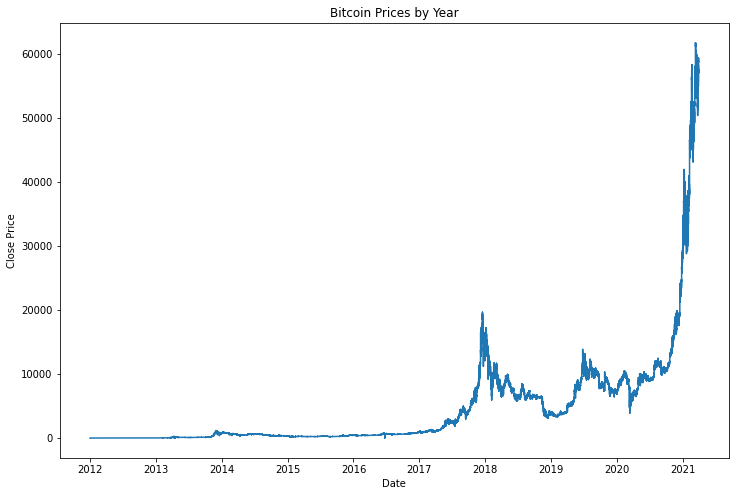

In [13]:
dataset = data.iloc[:, 4].values
date = data.index
plt.figure(figsize=(12,8))
plt.plot(date,dataset)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Bitcoin Prices by Year")
plt.show()

## Preprocessing Data

In [14]:
group = data.groupby("date")
data = group["Close"].mean()

In [15]:
data.shape

(3376,)

In [16]:
pd.DataFrame(data)

,Close
date,
2011-12-31,4.48
2012-01-01,4.81
2012-01-02,5.00
2012-01-03,5.25
2012-01-04,5.22
...,...
2021-03-27,55195.42
2021-03-28,55835.01
2021-03-29,56915.63


In [17]:
dataset = data.values

In [18]:
dataset

array([4.48250000e+00, 4.80666667e+00, 5.00000000e+00, ...,
       5.69156300e+04, 5.83493571e+04, 5.87781800e+04])

In [19]:
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(3376, 1)

In [20]:
dataset

array([[4.4825001e+00],
       [4.8066669e+00],
       [5.0000000e+00],
       ...,
       [5.6915629e+04],
       [5.8349355e+04],
       [5.8778180e+04]], dtype=float32)

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

## LSTM Train-Test Split

In [22]:
train_size = int(len(dataset)*0.95)
test_size = len(dataset)- train_size

In [23]:
train = dataset[0:train_size, :]
test = dataset[train_size:len(dataset), :]
print("train size: {}, test size: {}". format(len(train), len(test)))

train size: 3207, test size: 169


In [24]:
time_stemp = 10
dataX = []
dataY = []
for i in range(len(train) - time_stemp - 1):
    a = train[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)

In [25]:
trainX.shape

(3196, 10)

In [26]:
trainY.shape

(3196,)

In [27]:
dataX = []
dataY = []
for i in range(len(test) - time_stemp -1):
    a = test[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY)

In [28]:
testX.shape

(158, 10)

In [29]:
testY.shape

(158,)

In [30]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
trainX.shape

(3196, 1, 10)

In [32]:
trainY.shape

(3196,)

## LSTM Model

In [33]:
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(10, input_shape = (1, time_stemp)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss = "mean_squared_error",optimizer="adam")
model.fit(trainX, trainY, epochs=100, batch_size=32)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/100
100/100 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7513e-04
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 1.4567e-04
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 1.4458e-04
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 1.3165e-04
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.0298e-04
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 9.8226e-05
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 9.2750e-05
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 9.5567e-05
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 8.7006e-05
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 7.9829e-05
Epoch 12/100
100/100 [==============================] - 

## LSTM Prediction and Visualization

In [34]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

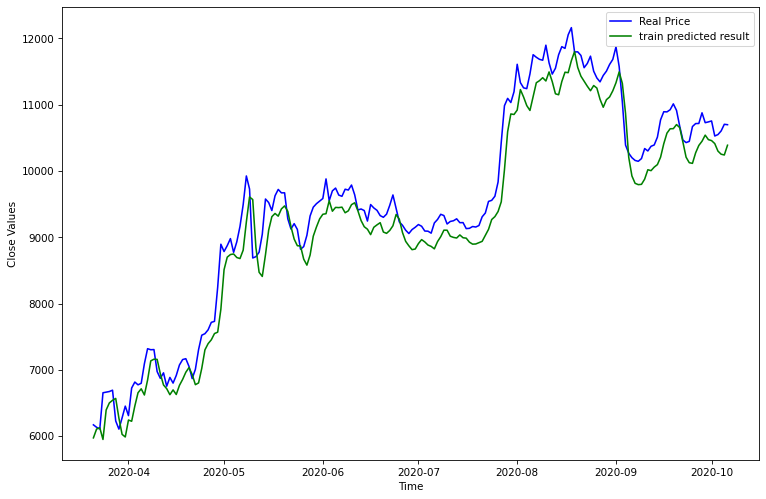

In [35]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict) + time_stemp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_stemp * 2) + 1:len(dataset) - 1, :] = testPredict

plt.figure(figsize=(12,8), dpi=75, facecolor ="w", edgecolor="k")
plt.plot(data.index[3000:3200],scaler.inverse_transform(dataset[3000:3200]),color ="b", label="Real Price")
plt.plot(data.index[3000:3200],trainPredictPlot[3000:3200], color ="g", label="train predicted result")
plt.xlabel("Time")
plt.ylabel("Close Values")
plt.legend()
plt.show()

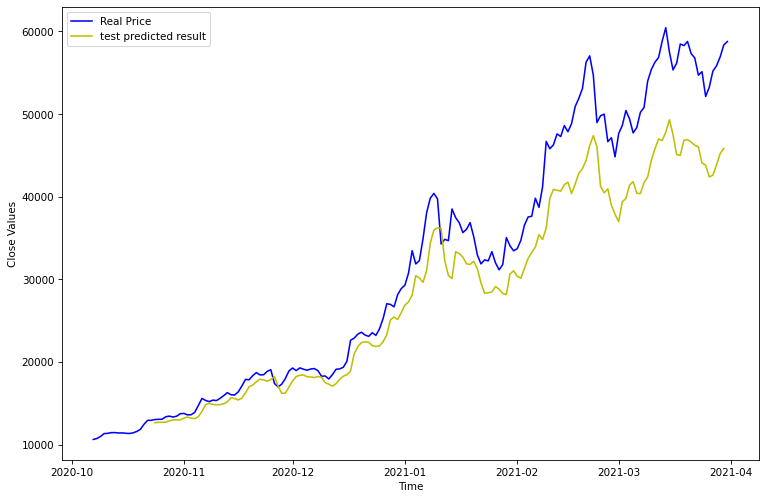

In [36]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict) + time_stemp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_stemp * 2) + 1:len(dataset) - 1, :] = testPredict

plt.figure(figsize=(12,8), dpi=75, facecolor ="w", edgecolor="k")
plt.plot(data.index[3200:],scaler.inverse_transform(dataset[3200:]),color ="b", label="Real Price")
plt.plot(data.index[3200:],testPredictPlot[3200:], color ="y", label="test predicted result")
plt.xlabel("Time")
plt.ylabel("Close Values")
plt.legend()
plt.show()

## RNN Model

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [38]:
dataset = data.values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(3376, 1)

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
train = dataset[0:train_size, :]
test = dataset[train_size:len(dataset), :]


## RNN Train-Test Split

In [40]:
time_stemp = 10
dataX = []
dataY = []
for i in range(len(train) - time_stemp - 1):
    a = train[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)

In [41]:
dataX = []
dataY = []
for i in range(len(test) - time_stemp -1):
    a = test[i:(i + time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY)

In [42]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],1))

In [43]:
regressor = Sequential()


regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (trainX.shape[1],1)))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


regressor.fit(trainX, trainY, epochs = 100, batch_size = 32)

Epoch 1/100
100/100 [==============================] - 5s 20ms/step - loss: 0.0403
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0070
Epoch 3/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0038
Epoch 4/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0024
Epoch 5/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0019
Epoch 6/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0013
Epoch 7/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0012
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0011
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 8.6524e-04
Epoch 10/100
100/100 [==============================] - 2s 21ms/step - loss: 7.5652e-04
Epoch 11/100
100/100 [==============================] - 2s 21ms/step - loss: 7.0466e-04
Epoch 12/100
100/100 [==============================] - 2s 20ms/step - lo

## RNN Prediction and Visualization

In [44]:
trainPredict = regressor.predict(trainX)
testPredict = regressor.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

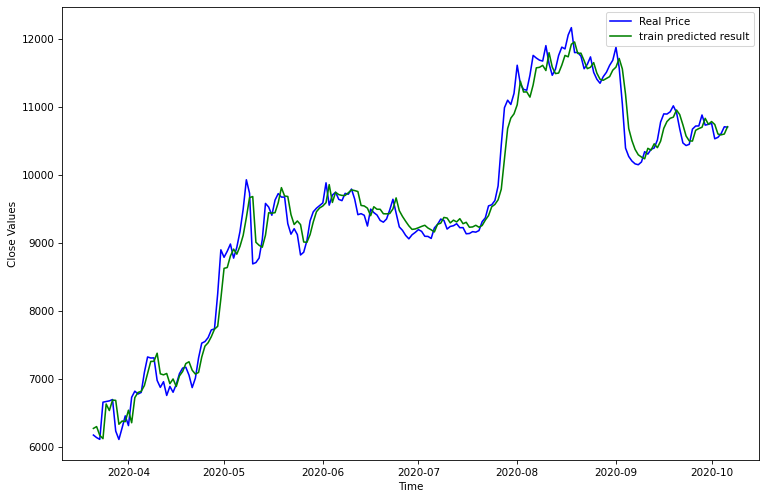

In [45]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict) + time_stemp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_stemp * 2) + 1:len(dataset) - 1, :] = testPredict

plt.figure(figsize=(12,8), dpi=75, facecolor ="w", edgecolor="k")
plt.plot(data.index[3000:3200],scaler.inverse_transform(dataset[3000:3200]),color ="b", label="Real Price")
plt.plot(data.index[3000:3200],trainPredictPlot[3000:3200], color ="g", label="train predicted result")
plt.xlabel("Time")
plt.ylabel("Close Values")
plt.legend()
plt.show()

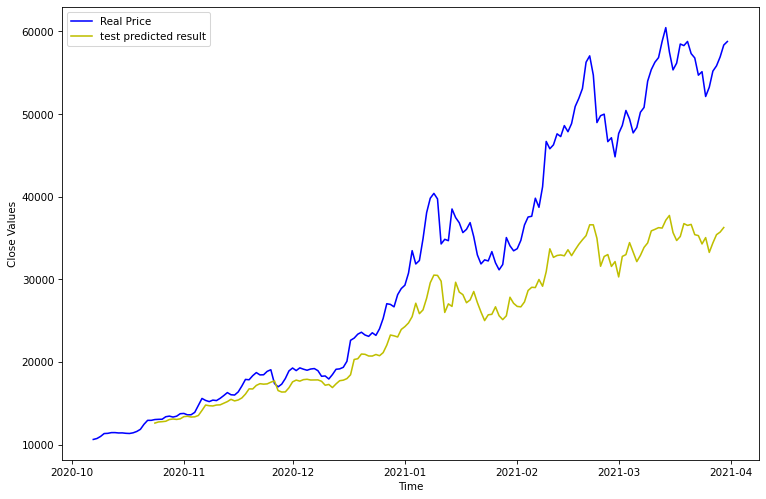

In [46]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict) + time_stemp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_stemp * 2) + 1:len(dataset) - 1, :] = testPredict

plt.figure(figsize=(12,8), dpi=75, facecolor ="w", edgecolor="k")
plt.plot(data.index[3200:],scaler.inverse_transform(dataset[3200:]),color ="b", label="Real Price")
plt.plot(data.index[3200:],testPredictPlot[3200:], color ="y", label="test predicted result")
plt.xlabel("Time")
plt.ylabel("Close Values")
plt.legend()
plt.show()

## Conclusion

When results are compared as to test score, it can be seen that LSTM model has better predicton. 
